# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**Bank marketing data**
* Source data represents 52,944 phone contacts made by a Portuguese retail bank with its customers to sell a deposit product
* Data that will be used for the analysis is randomly selected subset of the data consisting of 4119 records
* The target variable for each record is a binary outcome - successful or unsuccessful outcome
* The data is imbalanced - in the source data only 12.38% of the contacts resulted in a successful outcome
* The original dataset included 150 features, and then, through a feature selection process, it was narrowed to 20 features.
  * The feature selection included business intuition as well as an adapted forward selection method 
* The feature set in the data includes the following
  * Customer information
    * Age
    * Type of job
    * Marital status
    * Credit default status
    * Whether has housing loan
    * Whether has personal loan
  * Details about last contact in current campaign
    * Contact communication type
    * Month when contact was made
    * Day of the week of contact
    * Duration of the call during last contact
  * Other marketing details 
    * Number of contacts made during the campaign
    * Number of days since the last contact from a previous campaign
    * Number of contacts performed for the previous campaign
    * Outcome of previous marketing campaign
  * Macroeconomic factors 
    * Consumer price index
    * Consumer confidence
    * Euro IBOR 3-month rate
    * Number of employees

In [5]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import warnings

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [7]:
df = pd.read_csv('data/bank-additional.csv', sep = ';')

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [10]:
# Assuming df is your DataFrame
null_counts = df.isnull().sum()

print(null_counts)

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [11]:
job_distribution=df['job'].value_counts()
job_distribution

job
admin.           1012
blue-collar       884
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
unknown            39
Name: count, dtype: int64

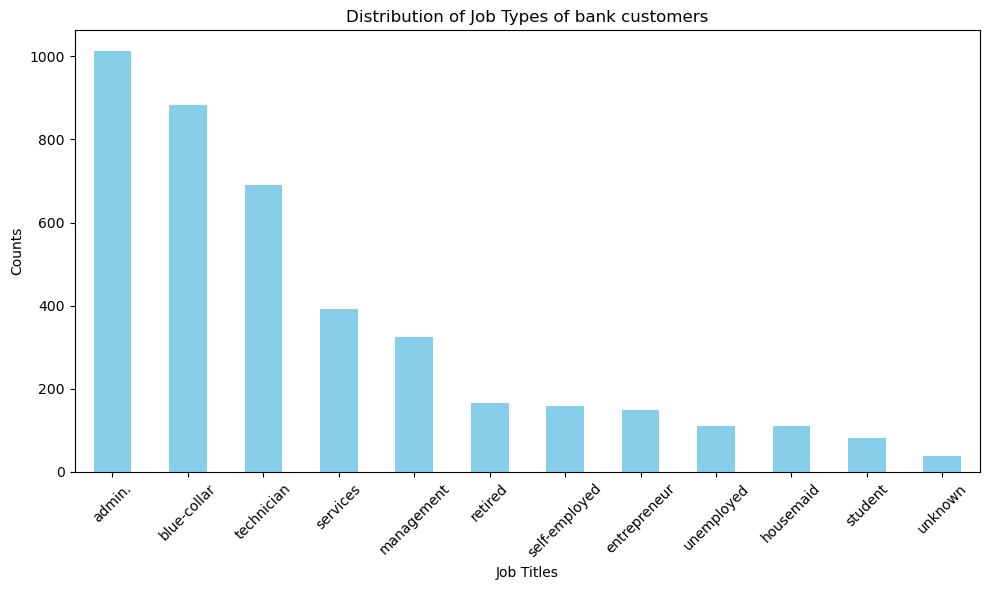

In [12]:
plt.figure(figsize=(10, 6))
job_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('Job Titles')
plt.ylabel('Counts')
plt.title('Distribution of Job Types of bank customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

In [13]:
marital_distribution=df['marital'].value_counts()
marital_distribution

marital
married     2509
single      1153
divorced     446
unknown       11
Name: count, dtype: int64

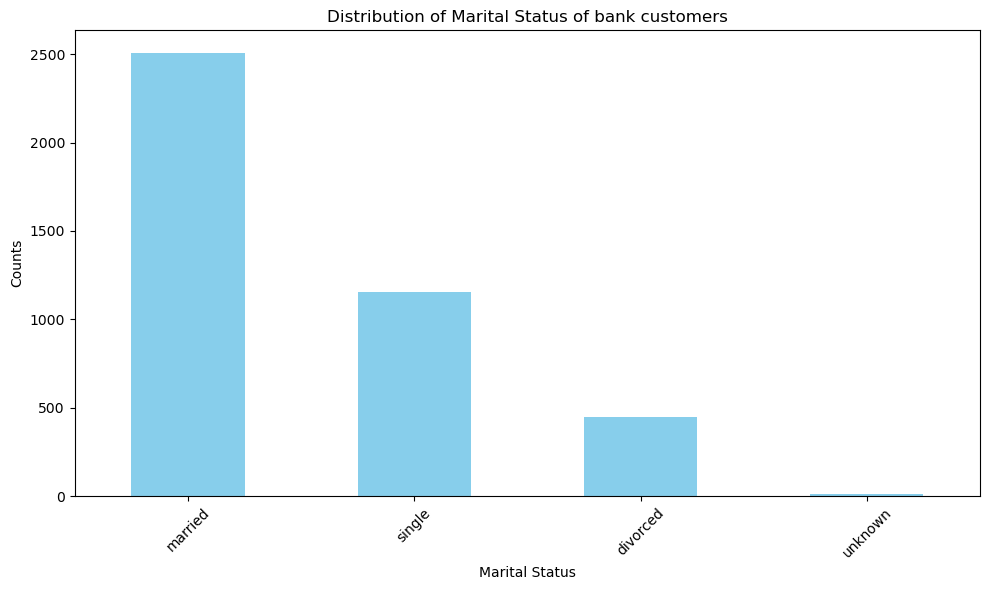

In [14]:
plt.figure(figsize=(10, 6))
marital_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('Marital Status')
plt.ylabel('Counts')
plt.title('Distribution of Marital Status of bank customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

In [15]:
edu_distribution=df['education'].value_counts()
edu_distribution

education
university.degree      1264
high.school             921
basic.9y                574
professional.course     535
basic.4y                429
basic.6y                228
unknown                 167
illiterate                1
Name: count, dtype: int64

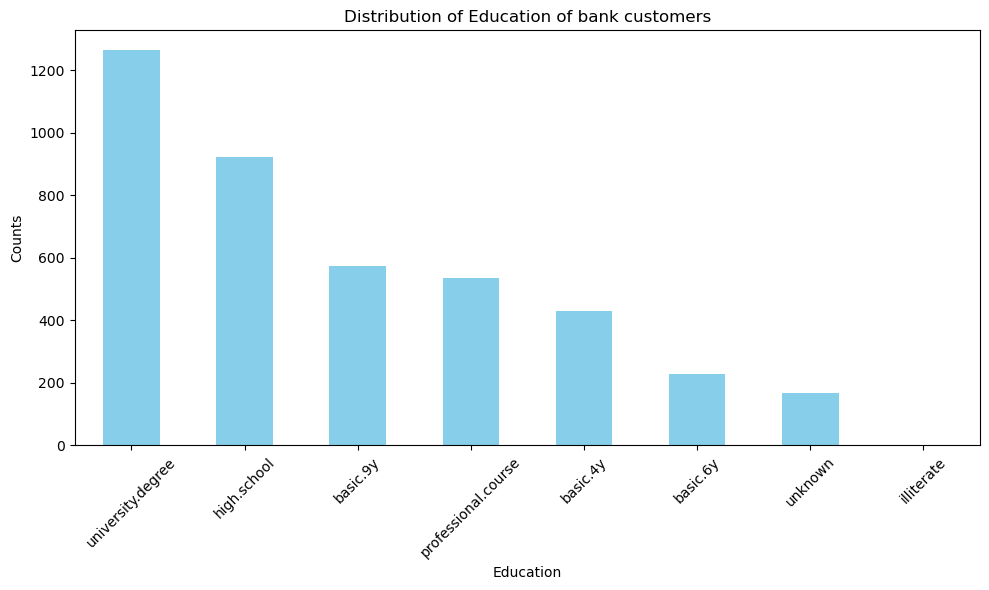

In [16]:
plt.figure(figsize=(10, 6))
edu_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('Education')
plt.ylabel('Counts')
plt.title('Distribution of Education of bank customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

In [17]:
default_distribution=df['default'].value_counts()
default_distribution

default
no         3315
unknown     803
yes           1
Name: count, dtype: int64

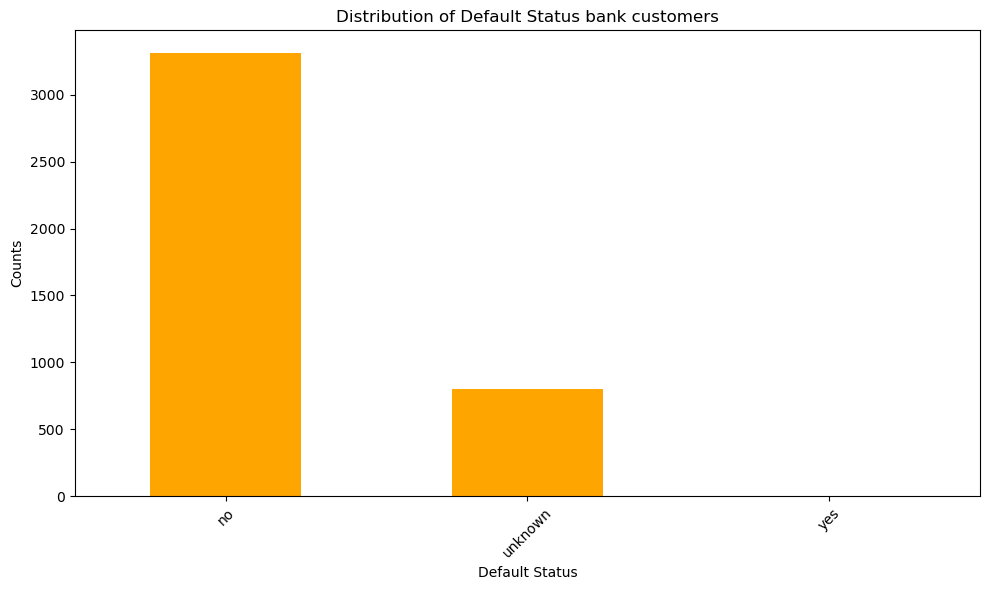

In [18]:
plt.figure(figsize=(10, 6))
default_distribution.plot(kind='bar', color='orange')
plt.xlabel('Default Status')
plt.ylabel('Counts')
plt.title('Distribution of Default Status bank customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

In [19]:
housing_distribution=df['housing'].value_counts()
housing_distribution

housing
yes        2175
no         1839
unknown     105
Name: count, dtype: int64

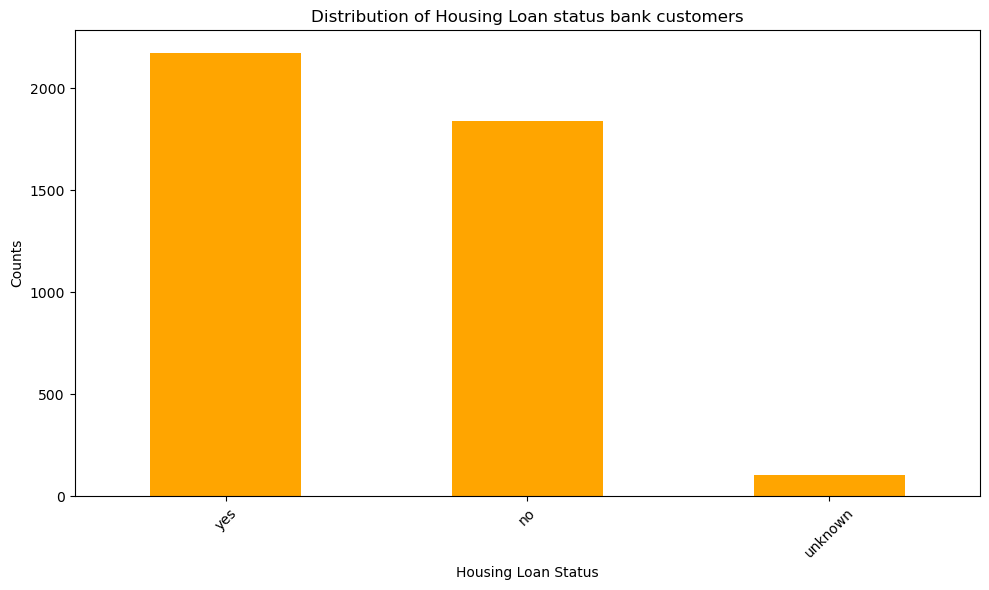

In [20]:
plt.figure(figsize=(10, 6))
housing_distribution.plot(kind='bar', color='orange')
plt.xlabel('Housing Loan Status')
plt.ylabel('Counts')
plt.title('Distribution of Housing Loan status bank customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

In [21]:
loan_distribution=df['loan'].value_counts()
loan_distribution

loan
no         3349
yes         665
unknown     105
Name: count, dtype: int64

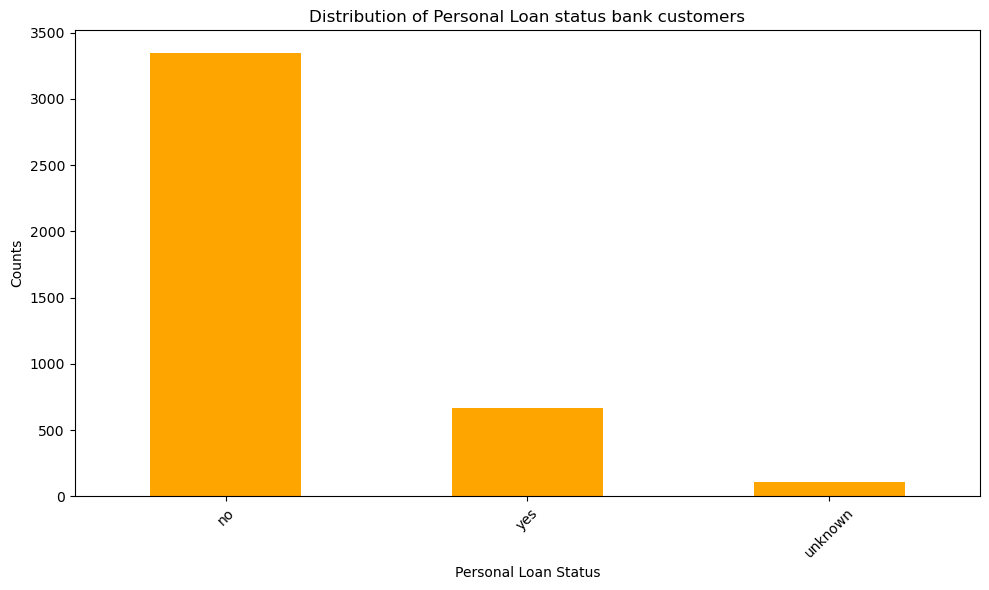

In [22]:
plt.figure(figsize=(10, 6))
loan_distribution.plot(kind='bar', color='orange')
plt.xlabel('Personal Loan Status')
plt.ylabel('Counts')
plt.title('Distribution of Personal Loan status bank customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

In [23]:
contact_distribution=df['contact'].value_counts()
contact_distribution

contact
cellular     2652
telephone    1467
Name: count, dtype: int64

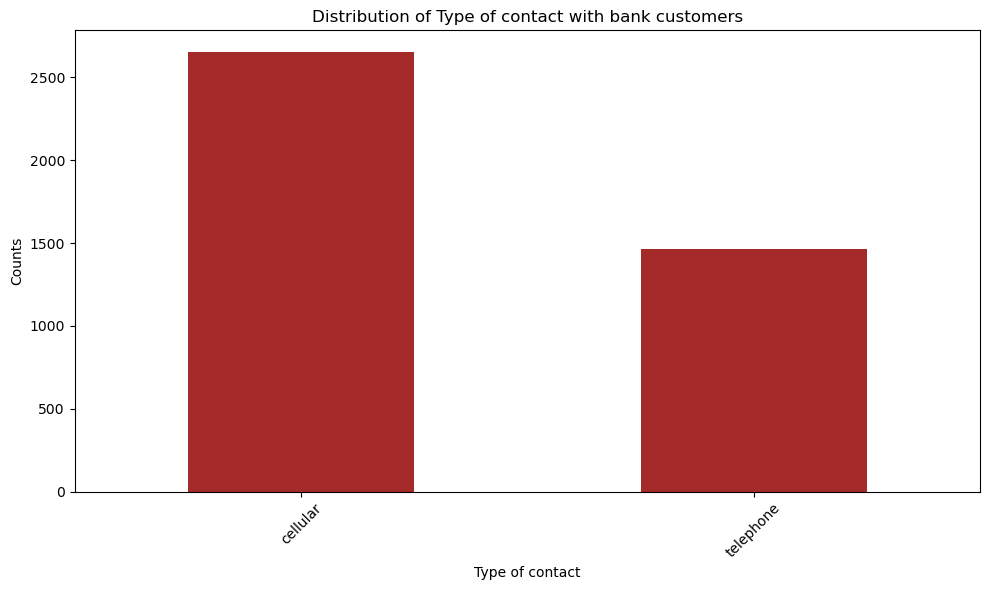

In [24]:
plt.figure(figsize=(10, 6))
contact_distribution.plot(kind='bar', color='brown')
plt.xlabel('Type of contact')
plt.ylabel('Counts')
plt.title('Distribution of Type of contact with bank customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

In [25]:
month_distribution=df['month'].value_counts()
month_distribution

month
may    1378
jul     711
aug     636
jun     530
nov     446
apr     215
oct      69
sep      64
mar      48
dec      22
Name: count, dtype: int64

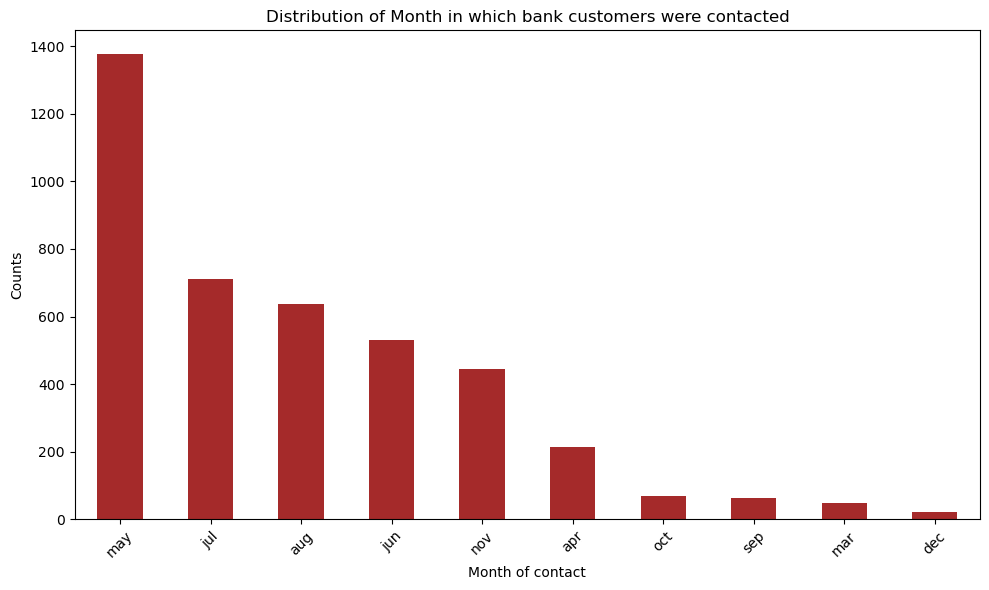

In [26]:
plt.figure(figsize=(10, 6))
month_distribution.plot(kind='bar', color='brown')
plt.xlabel('Month of contact')
plt.ylabel('Counts')
plt.title('Distribution of Month in which bank customers were contacted')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

In [27]:
day_distribution=df['day_of_week'].value_counts()
day_distribution

day_of_week
thu    860
mon    855
tue    841
wed    795
fri    768
Name: count, dtype: int64

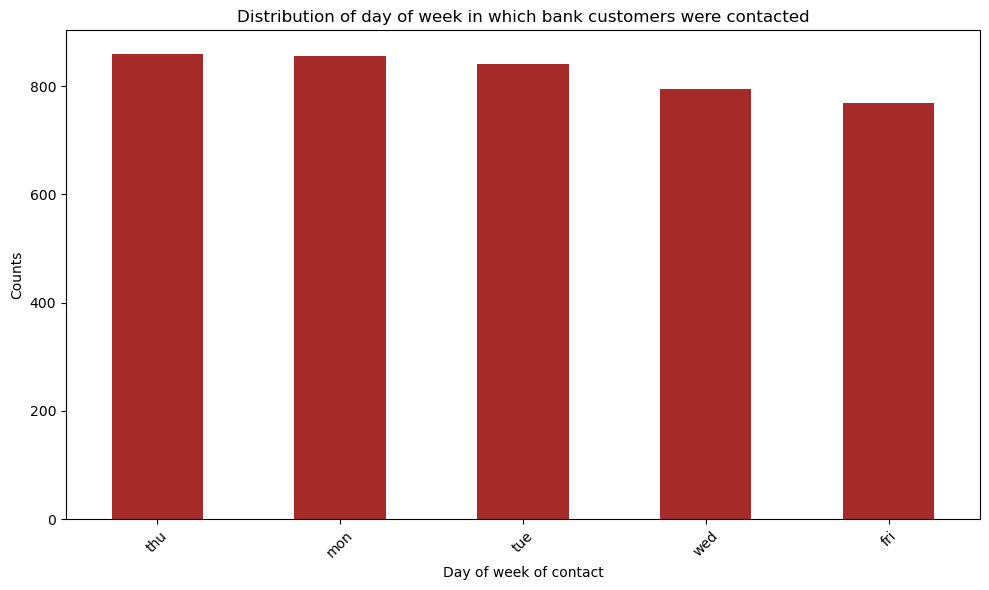

In [28]:
plt.figure(figsize=(10, 6))
day_distribution.plot(kind='bar', color='brown')
plt.xlabel('Day of week of contact')
plt.ylabel('Counts')
plt.title('Distribution of day of week in which bank customers were contacted')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

In [29]:
poutcome_distribution=df['poutcome'].value_counts()
poutcome_distribution

poutcome
nonexistent    3523
failure         454
success         142
Name: count, dtype: int64

In [30]:
target_distribution=df['y'].value_counts()
target_distribution

y
no     3668
yes     451
Name: count, dtype: int64

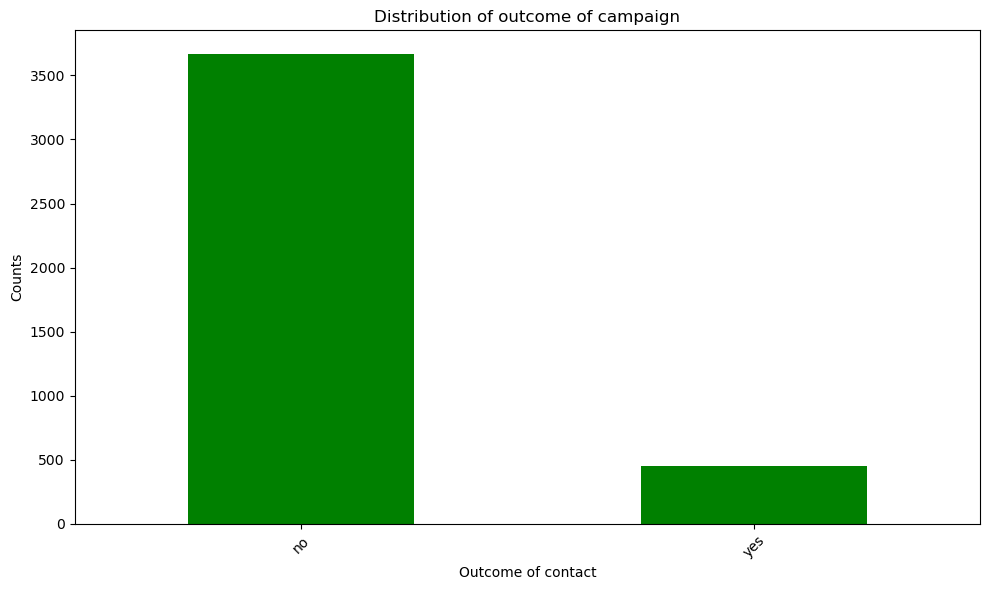

In [31]:
plt.figure(figsize=(10, 6))
target_distribution.plot(kind='bar', color='green')
plt.xlabel('Outcome of contact')
plt.ylabel('Counts')
plt.title('Distribution of outcome of campaign')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

**Assessment of categorical variables - changing data type**
* Default - convert into boolean - False if No and True otherwise
  * Most of the data has Default as 'No' - and the rest is mostly "Unknown." If the Default is unknown for risk management purposes we should assume it to be True 
* Housing - convert into boolean - True if Yes and False otherwise
  * If it is unknown whether the customer has a Housing loan, then it is safe to assume it is False
* Loan - convert into boolean - True if Yes and False otherwise
  * If it is unknown whether the customer has a Personal loan, then it is safe to assume it is False
* Contact - rename it to Cellular_Contact and convert into boolean - True if Cellular and False if Telephone
  * Since Contact can be only two values, one can convert it into a boolean
* 'y' - Target - True of Yes and False if No
  * Since 'y' has only two values, can convert it into a boolean 

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

**Business objective of the project**
* Create a model that will predict whether a customer will purchase a "deposit product" when offered over the phone
* The model will help target customers who are more likely to "purchase" the deposit product and exclude "customers" who are not likely to purchase the product. Focusing on a subset of customers will help reduce marketing spending.
* Given that only ~13% of customers buy the Deposit Product, the model should have low rates of misclassifying a customer that would have purchased the product as "unlikely to buy" and hence not targeted. Such model errors would result in lost customer revenues
* The model should also be reasonably accurate in classifying a customer as "likely to purchase" because targeting a customer that would never buy the deposit product would result in wasted marketing effort and spend
* The model should also help identify factors the bank can control that lead to customers buying the product. For example, it could be the day and month of the year when the campaign is run or whether contacting via telephone or cellphone is more effective.
* The model can also inform actions for better outcomes in future campaigns, not just the current campaign. For example, if a certain number of contacts in the previous campaign and a certain number of days between contacts in the last campaign predicts success in the current campaign, then it can used in the current campaign to have success in the future

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [37]:
df_encoded=df.copy()

In [38]:
df_encoded['default'] = df_encoded['default'].apply(lambda x: False if x == 'no' else True)
df_encoded['housing'] = df_encoded['housing'].apply(lambda x: True if x == 'yes' else False)
df_encoded['loan'] = df_encoded['loan'].apply(lambda x: True if x == 'yes' else False)
df_encoded['cellular_contact'] = df_encoded['contact'].apply(lambda x: True if x == 'cellular' else False)
df_encoded['target'] = df_encoded['y'].apply(lambda x: True if x == 'yes' else False)

# Drop the old 'Contact' and 'y' columns
df_encoded.drop(columns=['contact', 'y'], inplace=True)

In [39]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               4119 non-null   int64  
 1   job               4119 non-null   object 
 2   marital           4119 non-null   object 
 3   education         4119 non-null   object 
 4   default           4119 non-null   bool   
 5   housing           4119 non-null   bool   
 6   loan              4119 non-null   bool   
 7   month             4119 non-null   object 
 8   day_of_week       4119 non-null   object 
 9   duration          4119 non-null   int64  
 10  campaign          4119 non-null   int64  
 11  pdays             4119 non-null   int64  
 12  previous          4119 non-null   int64  
 13  poutcome          4119 non-null   object 
 14  emp.var.rate      4119 non-null   float64
 15  cons.price.idx    4119 non-null   float64
 16  cons.conf.idx     4119 non-null   float64


In [40]:
# Assuming df_encoded is your DataFrame
categorical_columns = ['job', 'marital', 'education', 'month', 'day_of_week', 'poutcome']

# One-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=categorical_columns)

print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            4119 non-null   int64  
 1   default                        4119 non-null   bool   
 2   housing                        4119 non-null   bool   
 3   loan                           4119 non-null   bool   
 4   duration                       4119 non-null   int64  
 5   campaign                       4119 non-null   int64  
 6   pdays                          4119 non-null   int64  
 7   previous                       4119 non-null   int64  
 8   emp.var.rate                   4119 non-null   float64
 9   cons.price.idx                 4119 non-null   float64
 10  cons.conf.idx                  4119 non-null   float64
 11  euribor3m                      4119 non-null   float64
 12  nr.employed                    4119 non-null   f

In [41]:
X = df_encoded.drop(columns=['duration', 'target'])
y=df_encoded['target']

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
train_percentage = y_train.value_counts(normalize=True) * 100

print(train_percentage)

target
False    88.900451
True     11.099549
Name: proportion, dtype: float64


In [45]:
test_percentage = y_test.value_counts(normalize=True) * 100

print(test_percentage)

target
False    89.401294
True     10.598706
Name: proportion, dtype: float64


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

**Baseline classifier model**
* We develop a dummy classifier model with default parameters
* We fit the model with training data set
* We generate predictions based on the testing data set
* Upon calculating the accuracy score - we get 0.894
* So classifier models need to have an accuracy score higher than 0.894
* In addition, we did calculate precision, recall and f1_score and the baseline model does not generate any meaningful scores

In [48]:
# Create a DummyClassifier
dummy_clf = DummyClassifier()

# Fit the model
dummy_clf.fit(X_train, y_train)

# Make predictions
y_pred = dummy_clf.predict(X_test)

# Evaluate the model
baseline_accuracy = accuracy_score(y_test, y_pred)

print("Baseline model accuracy:", baseline_accuracy)


Baseline model accuracy: 0.8940129449838188


In [49]:
# Calculate precision
baseline_precision = precision_score(y_test, y_pred,zero_division=1)

# Calculate recall
baseline_recall = recall_score(y_test, y_pred,zero_division=1)

# Calculate F1 score
baseline_f1 = f1_score(y_test, y_pred,zero_division=1)

print("Baseline model precision:", baseline_precision)
print("Baseline model recall:", baseline_recall)
print("Baseline model F1 score:", baseline_f1)

Baseline model precision: 1.0
Baseline model recall: 0.0
Baseline model F1 score: 0.0


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [51]:
# Create a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
# Start the timer
lgr_start_time = time.time()
# Train the model
log_reg.fit(X_train, y_train)

# Stop the timer
lgr_end_time = time.time()

# Calculate the elapsed time
lgr_train_time = lgr_end_time - lgr_start_time

print(f"Time to fit the model: {lgr_train_time:.4f} seconds")

Time to fit the model: 0.1340 seconds


### Problem 9: Score the Model

What is the accuracy of your model?

In [53]:
# Make predictions
y_pred = log_reg.predict(X_test)
y_train_pred=log_reg.predict(X_train)

# Calculate accuracy
lgr_test_accuracy = accuracy_score(y_test, y_pred)
lgr_train_accuracy=accuracy_score(y_train, y_train_pred)
# Calculate precision
lgr_precision = precision_score(y_test, y_pred, zero_division=1)

# Calculate recall
lgr_recall = recall_score(y_test, y_pred, zero_division=1)

# Calculate F1 score
lgr_f1 = f1_score(y_test, y_pred, zero_division=1)

print("Logistic Regression model test accuracy:", lgr_test_accuracy)
print("Logistic Regression model train accuracy:", lgr_train_accuracy)
print("Logistic Regression model precision:", lgr_precision)
print("Logistic Regression model recall:", lgr_recall)
print("Logistic Regression model F1 score:", lgr_f1)


Logistic Regression model test accuracy: 0.9021035598705501
Logistic Regression model train accuracy: 0.9025320846340618
Logistic Regression model precision: 0.6388888888888888
Logistic Regression model recall: 0.17557251908396945
Logistic Regression model F1 score: 0.2754491017964072


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [55]:
# Create a KNN model
knn = KNeighborsClassifier()

knn_start_time = time.time()

# Train the model
knn.fit(X_train, y_train)

knn_end_time = time.time()
# Calculate the elapsed time
knn_train_time = knn_end_time - knn_start_time

print(f"Time to fit the KNN model: {knn_train_time:.4f} seconds")

# Make predictions
y_pred_test_knn = knn.predict(X_test)
y_pred_train_knn = knn.predict(X_train)

# Evaluate the model
accuracy_test_knn = accuracy_score(y_test, y_pred_test_knn)
accuracy_train_knn = accuracy_score(y_train, y_pred_train_knn)
print("KNN model test accuracy:", accuracy_test_knn)
print("KNN model train accuracy:", accuracy_train_knn)

Time to fit the KNN model: 0.0059 seconds
KNN model test accuracy: 0.9045307443365695
KNN model train accuracy: 0.9112036073534513


In [56]:
dt_model = DecisionTreeClassifier()
dt_start_time = time.time()
dt_model.fit(X_train, y_train)

dt_end_time = time.time()
# Calculate the elapsed time
dt_train_time = dt_end_time - dt_start_time

print(f"Time to fit the DT model: {dt_train_time:.4f} seconds")

# Make predictions
y_pred_test_dt_model = dt_model.predict(X_test)
y_pred_train_dt_model = dt_model.predict(X_train)

# Evaluate the model
accuracy_test_dt_model = accuracy_score(y_test, y_pred_test_dt_model)
accuracy_train_dt_model = accuracy_score(y_train, y_pred_train_dt_model)
print("Decision Tree model test accuracy:", accuracy_test_dt_model)
print("Decision Tree model train accuracy:", accuracy_train_dt_model)


Time to fit the DT model: 0.0283 seconds
Decision Tree model test accuracy: 0.8325242718446602
Decision Tree model train accuracy: 0.9996531390912244


In [57]:
svm_model = SVC()
svm_start_time = time.time()
svm_model.fit(X_train, y_train)
svm_end_time = time.time()
svm_train_time = svm_end_time - svm_start_time

print(f"Time to fit the SVM model: {svm_train_time:.4f} seconds")
# Make predictions
y_pred_test_svm_model = svm_model.predict(X_test)
y_pred_train_svm_model = svm_model.predict(X_train)

# Evaluate the model
accuracy_test_svm_model = accuracy_score(y_test, y_pred_test_svm_model)
accuracy_train_svm_model = accuracy_score(y_train, y_pred_train_svm_model)
print("SVM model test accuracy:", accuracy_test_svm_model)
print("SVM Tree model train accuracy:", accuracy_train_svm_model)


Time to fit the SVM model: 0.1164 seconds
SVM model test accuracy: 0.9061488673139159
SVM Tree model train accuracy: 0.8976760319112036


In [58]:
classifer_model_data={'Model':['Logistic Regression', 'KNeighborsClassifier', 'Decision Tree', 'SVM'],
                      'Train Time' : [lgr_train_time, knn_train_time, dt_train_time, svm_train_time],
                      'Train Accuracy' : [lgr_train_accuracy,accuracy_train_knn,accuracy_train_dt_model,accuracy_train_svm_model],
                      'Test Accuracy' : [lgr_test_accuracy,accuracy_test_knn,accuracy_test_dt_model,accuracy_test_svm_model]}
classifier_model_df=pd.DataFrame(classifer_model_data)
classifier_model_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.133976,0.902532,0.902104
1,KNeighborsClassifier,0.005874,0.911204,0.904531
2,Decision Tree,0.028266,0.999653,0.832524
3,SVM,0.116422,0.897676,0.906149


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

**Selecting subset of features to reduce model complexity**
* We used Logisitic Regression model with Recursive Feature Elimination to select 20 features out of 56 features
* RFE resulted in the following 20 features
  * Feature releated to prior campaign
    * previous
    * poutcome_failure
    * poutcome_success'
  * Features related to macro economic condition
    * euribor3m
  * Features related to telemarketing contact - type of contact and month contacted
    * cellular_contact',
    * 'month_jul'
    * 'month_jun'
    * 'month_mar'
    * 'month_may'
    * 'month_oct'
  * Features about customer job, marital statis and education
    * job_entrepreneur
    * 'job_housemai
    * 'job_managemen
    * 'job_retire
    * 'job_self-employe
    *  'job_stude
    *  'job_unkno
    *  'marital_unkno
    *   'education_professional.cou
    * , 'education_university.deg
* Using a smaller set of features model accuracy for test data improved or stayed about the same
  * Logistic Regression Test Accuracy: 0.9037216828478964
  * KNN model Test test accuracy: 0.9045307443365695
  * Decision Tree model test accuracy: 0.88915857605178
  * SVM model test accuracy: 0.9045307443365695cess'

In [61]:
# Recursive Feature Elimination
model = LogisticRegression(max_iter=10000)
rfe_selector = RFE(model, n_features_to_select=20)
X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
X_test_rfe = rfe_selector.transform(X_test)

In [62]:
# Get the selected features
selected_features_rfe = X.columns[rfe_selector.support_]
print("Selected features using RFE:")
print(selected_features_rfe)

Selected features using RFE:
Index(['previous', 'euribor3m', 'cellular_contact', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_student', 'job_unknown', 'marital_unknown',
       'education_professional.course', 'education_university.degree',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_oct',
       'poutcome_failure', 'poutcome_success'],
      dtype='object')


In [63]:
print("Logisitc Regression with only 20 features")
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)
y_train_pred=model.predict(X_train_rfe)
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Train Accuracy: {accuracy_score(y_train, y_train_pred)}')

Logisitc Regression with only 20 features
Test Accuracy: 0.9037216828478964
Train Accuracy: 0.9004509191814083


In [64]:
print("KNNeighbors with only 20 features")
knn_rfe = KNeighborsClassifier()



# Train the model
knn_rfe.fit(X_train_rfe, y_train)



# Make predictions
y_pred_test_knn_rfe = knn_rfe.predict(X_test_rfe)
y_pred_train_knn_rfe = knn_rfe.predict(X_train_rfe)

# Evaluate the model
accuracy_test_knn_rfe = accuracy_score(y_test, y_pred_test_knn_rfe)
accuracy_train_knn_rfe = accuracy_score(y_train, y_pred_train_knn_rfe)
print("KNN model test accuracy:", accuracy_test_knn)
print("KNN model train accuracy:", accuracy_train_knn)

KNNeighbors with only 20 features
KNN model test accuracy: 0.9045307443365695
KNN model train accuracy: 0.9112036073534513


In [65]:
print("Decision Tree with only 20 features")
dt_model_rfe = DecisionTreeClassifier()

dt_model_rfe.fit(X_train_rfe, y_train)



# Make predictions
y_pred_test_dt_model_rfe = dt_model_rfe.predict(X_test_rfe)
y_pred_train_dt_model_rfe = dt_model_rfe.predict(X_train_rfe)

# Evaluate the model
accuracy_test_dt_model_rfe = accuracy_score(y_test, y_pred_test_dt_model_rfe)
accuracy_train_dt_model_rfe = accuracy_score(y_train, y_pred_train_dt_model_rfe)
print("Decision Tree model test accuracy:", accuracy_test_dt_model_rfe)
print("Decision Tree model train accuracy:", accuracy_train_dt_model_rfe)

Decision Tree with only 20 features
Decision Tree model test accuracy: 0.8859223300970874
Decision Tree model train accuracy: 0.9566423864030523


In [66]:
print("SVM with only 20 features")
svm_model_rfe = SVC()
svm_model_rfe.fit(X_train_rfe, y_train)

# Make predictions
y_pred_test_svm_model_rfe = svm_model_rfe.predict(X_test_rfe)
y_pred_train_svm_model_rfe = svm_model_rfe.predict(X_train_rfe)

# Evaluate the model
accuracy_test_svm_model_rfe = accuracy_score(y_test, y_pred_test_svm_model_rfe)
accuracy_train_svm_model_rfe = accuracy_score(y_train, y_pred_train_svm_model_rfe)
print("SVM model test accuracy:", accuracy_test_svm_model_rfe)
print("SVM Tree model train accuracy:", accuracy_train_svm_model_rfe)

SVM with only 20 features
SVM model test accuracy: 0.9045307443365695
SVM Tree model train accuracy: 0.9004509191814083


**Finding optimal models**
* To find the optimal model - given the imbalanced dataset we used "roc_auc" as the metric to maximize
* We used GridSearch CV to find the optimal hyperparameters for each of the different classifer models
* Logistic Regression optimal model and Decision Tree yielded the best ROC_AUC score of around 0.75
* Logistic Regression optimal model findings
    * Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
    * 
Best Cross-Validation ROC AUC: 0.787233688027305
* KNeighborsClassifier optimal model findings
    *  Best Hyperparameters KNN: {'n_neighbors': 13}
    *  
Best Cross-Validation Accuracy KNN: 0.735870254248903
    *  73
Test Set ROC AUC: 0.694414700701
* Decision Tree optimal model findings
    * Best Hyperparameters: {'max_depth': 4}
    * 
Best Cross-Validation Accuracy: 0.759578248260081
    * 41
Test Set ROC AUC: 0.746202203723
* SVM Optimal model findings
    * Best SVM Hyperparameters: {'kernel': 'sigmoid'}
    * 
Best SVM Cross-Validation Accuracy: 0.728745214748568
    * 92
Test Set ROC AUC: 0.6914165313806087532918476

In [68]:
# Define the Logistic Regression model
print("Finding the optimal Logistic Regression Model")
lgr = LogisticRegression(solver='liblinear')

# Define the parameter grid for hyperparameters
param_grid_lgr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Initialize GridSearchCV with the model and parameter grid
grid_search_lgr = GridSearchCV(estimator=lgr, param_grid=param_grid_lgr, cv=5, scoring='roc_auc')

# Fit GridSearchCV to the training data
grid_search_lgr.fit(X_train_rfe, y_train)


y_pred_test_lgr = grid_search_lgr.best_estimator_.predict(X_test_rfe)
y_pred_train_lgr=grid_search_lgr.best_estimator_.predict(X_train_rfe)
test_lgr_accuracy = accuracy_score(y_test, y_pred_test_lgr)
train_lgr_accuracy = accuracy_score(y_train, y_pred_train_lgr)
# Get the best parameters and best score
best_params_lgr = grid_search_lgr.best_params_
best_score_lgr = grid_search_lgr.best_score_

# Predict on the test set using the best model
y_pred_proba_lgr = grid_search_lgr.best_estimator_.predict_proba(X_test_rfe)[:, 1]
test_roc_auc_lgr = roc_auc_score(y_test, y_pred_proba_lgr)

print(f"Best Hyperparameters: {best_params_lgr}")
print(f"Best Cross-Validation ROC AUC: {best_score_lgr}")
print(f"Test Set Accuracy: {test_lgr_accuracy}")
print(f"Train Set Accuracy: {train_lgr_accuracy}")
print(f"Test Set ROC AUC: {test_roc_auc_lgr}")

Finding the optimal Logistic Regression Model
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation ROC AUC: 0.7872336880273056
Test Set Accuracy: 0.9061488673139159
Train Set Accuracy: 0.9004509191814083
Test Set ROC AUC: 0.7484715553866879


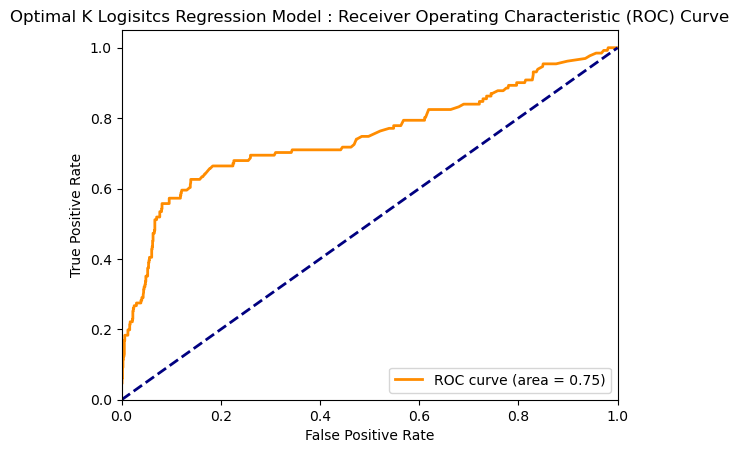

In [69]:
# Calculate the ROC curve
fpr_lgr, tpr_lgr, thresholds_lgr = roc_curve(y_test, y_pred_proba_lgr)

# Calculate the AUC (Area Under the Curve)
roc_auc_lgr = auc(fpr_lgr, tpr_lgr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_lgr, tpr_lgr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lgr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimal K Logisitcs Regression Model : Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [70]:
# Define the KNN model
print("Finding the optimal KNN Model")
knn_grid = KNeighborsClassifier()

# Define the parameter grid for the number of neighbors
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9,11,13]
}

# Initialize GridSearchCV with the model and parameter grid
grid_search_knn = GridSearchCV(estimator=knn_grid, param_grid=param_grid_knn, cv=5, scoring='roc_auc')

# Fit GridSearchCV to the training data
grid_search_knn.fit(X_train_rfe, y_train)

# Get the best parameters and best score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

# Predict on the test set using the best model
y_pred_test_knn = grid_search_knn.best_estimator_.predict(X_test_rfe)
y_pred_train_knn=grid_search_knn.best_estimator_.predict(X_train_rfe)
test_knn_accuracy = accuracy_score(y_test, y_pred_test_knn)
train_knn_accuracy = accuracy_score(y_train, y_pred_train_knn)

y_pred_proba_knn = grid_search_knn.best_estimator_.predict_proba(X_test_rfe)[:, 1]
test_roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)

print(f"Best Hyperparameters KNN: {best_params_knn}")
print(f"Best Cross-Validation Accuracy KNN: {best_score_knn}")
print(f"Test Set Accuracy: {test_knn_accuracy}")
print(f"Train Set Accuracy: {train_knn_accuracy}")
print(f"Test Set ROC AUC: {test_roc_auc_knn}")

Finding the optimal KNN Model
Best Hyperparameters KNN: {'n_neighbors': 13}
Best Cross-Validation Accuracy KNN: 0.7358702542489035
Test Set Accuracy: 0.9037216828478964
Train Set Accuracy: 0.9028789455428373
Test Set ROC AUC: 0.6944147007011847


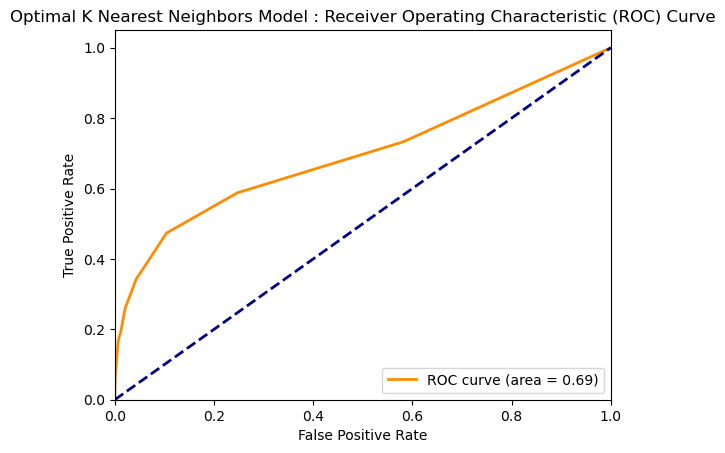

In [71]:
# Calculate the ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba_knn)

# Calculate the AUC (Area Under the Curve)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimal K Nearest Neighbors Model : Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [72]:
# Define the Decision Tree model
print("Finding the optimal Decision Tree Model")
dt_grid = DecisionTreeClassifier()

# Define the parameter grid for max_depth
param_grid_dt = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
}

# Initialize GridSearchCV with the model and parameter grid
grid_search_dt = GridSearchCV(estimator=dt_grid, param_grid=param_grid_dt, cv=5, scoring='roc_auc')

# Fit GridSearchCV to the training data
grid_search_dt.fit(X_train_rfe, y_train)

# Get the best parameters and best score
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

# Predict on the test set using the best model
y_pred_test_dt = grid_search_dt.best_estimator_.predict(X_test_rfe)
y_pred_train_dt = grid_search_dt.best_estimator_.predict(X_train_rfe)
test_dt_accuracy = accuracy_score(y_test, y_pred_test_dt)
train_dt_accuracy = accuracy_score(y_train, y_pred_train_dt)

# Predict on the test set using the best model
y_pred_proba_dt = grid_search_dt.best_estimator_.predict_proba(X_test_rfe)[:, 1]
test_roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)


print(f"Best Hyperparameters: {best_params_dt}")
print(f"Best Cross-Validation Accuracy: {best_score_dt}")
print(f"Test Set Accuracy: {test_dt_accuracy}")
print(f"Train Set Accuracy: {train_dt_accuracy}")
print(f"Test Set ROC AUC: {test_roc_auc_dt}")

Finding the optimal Decision Tree Model
Best Hyperparameters: {'max_depth': 4}
Best Cross-Validation Accuracy: 0.7595782482600816
Test Set Accuracy: 0.9029126213592233
Train Set Accuracy: 0.9039195282691641
Test Set ROC AUC: 0.7462022037235329


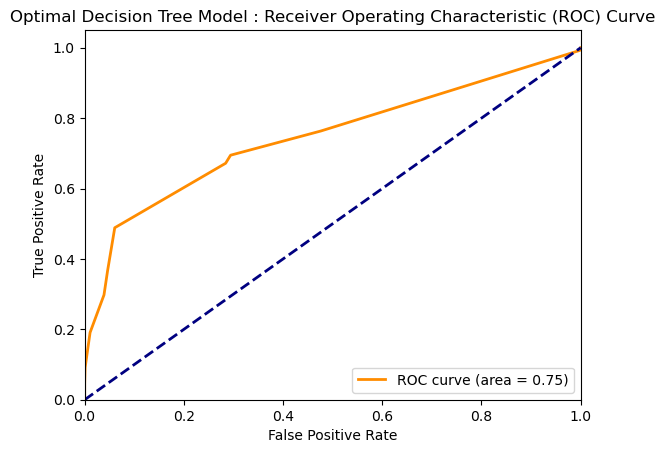

In [73]:
# Calculate the ROC curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)

# Calculate the AUC (Area Under the Curve)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimal Decision Tree Model : Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [74]:
print("Finding the optimal SVM Model")
svm_grid = SVC(probability=True)
param_grid_svm = {    
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
# Initialize GridSearchCV with the model and parameter grid
grid_search_svm = GridSearchCV(estimator=svm_grid, param_grid=param_grid_svm, cv=5, scoring='roc_auc')

# Fit GridSearchCV to the training data
grid_search_svm.fit(X_train_rfe, y_train)

# Get the best parameters and best score
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

y_pred_proba_svm = grid_search_svm.best_estimator_.predict_proba(X_test_rfe)[:, 1]
test_roc_auc_svm= roc_auc_score(y_test, y_pred_proba_svm)

# Predict on the test set using the best model
y_test_pred_svm = grid_search_svm.best_estimator_.predict(X_test_rfe)
y_train_pred_svm = grid_search_svm.best_estimator_.predict(X_train_rfe)
test_svm_accuracy = accuracy_score(y_test, y_test_pred_svm)
train_svm_accuracy = accuracy_score(y_train, y_train_pred_svm)

print(f"Best SVM Hyperparameters: {best_params_svm}")
print(f"Best SVM Cross-Validation Accuracy: {best_score_svm}")
print(f"Test Set Accuracy: {test_svm_accuracy}")
print(f"Train Set Accuracy: {train_svm_accuracy}")
print(f"Test Set ROC AUC: {test_roc_auc_svm}")

Finding the optimal SVM Model
Best SVM Hyperparameters: {'kernel': 'sigmoid'}
Best SVM Cross-Validation Accuracy: 0.7287452147485685
Test Set Accuracy: 0.9029126213592233
Train Set Accuracy: 0.8980228928199792
Test Set ROC AUC: 0.6914027149321267


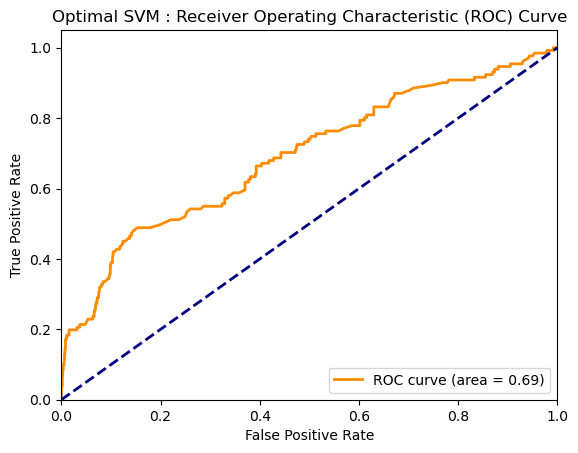

In [75]:
# Calculate the ROC curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_proba_svm)

# Calculate the AUC (Area Under the Curve)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimal SVM : Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### Questions